# Introduction

The documents similarity measurements have several applications in the real world like to find the **mirror site**, **plagarism checking** etc. Here in this report I will descuss about the time complexities of two of the similarity measurements: **Jaccard's** and **cosine** similarity measurement theoretically as well as emperically. Also, the various types of implementation of cosine similarity measures like vector representation and sparse dictionary representaion will be compared with each other. After that all pair similarity measurements and its time complexity will be compared for both Jaccard's and cosine implemention and various other observations and how emperical findings differ from the theoretical predictions also will be dicussed. Finally, Map Reduce paradigm will be used to implement parallel processing for calculating all pair similarity.

In [1]:
# imports all the necessary pyhton modules
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
nltk.download('brown')
from nltk.corpus import brown
import random
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import pandas as pd
from collections import defaultdict
from multiprocessing import Pool
print(brown.sents()[:5])




[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'rep

In [2]:
list_of_words = [j for i in brown.sents() for j in i]

In [3]:
print(list_of_words[:20])


['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that']


In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
st = stopwords.words('english')
list_of_words1= [i.lower() for i in list_of_words if i.isalpha()== True]
new_list_of_words = [i for i in list_of_words1 if i not in st]

len(new_list_of_words)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


509267

In [5]:
#Generates a big dictionary so that it can be used to generate different documents
dict_ = {}
for i in new_list_of_words:
  dict_[i] = dict_.get(i,0)+1
dict_key_list = list(dict_.keys())
print(dict_)
print(len(dict_))


{'fulton': 17, 'county': 155, 'grand': 48, 'jury': 67, 'said': 1961, 'friday': 60, 'investigation': 51, 'recent': 179, 'primary': 96, 'election': 77, 'produced': 90, 'evidence': 204, 'irregularities': 8, 'took': 426, 'place': 570, 'presentments': 1, 'city': 393, 'executive': 55, 'committee': 168, 'charge': 122, 'deserves': 16, 'praise': 17, 'thanks': 37, 'atlanta': 35, 'manner': 124, 'conducted': 55, 'term': 79, 'charged': 57, 'superior': 46, 'court': 230, 'judge': 77, 'durwood': 1, 'pye': 1, 'investigate': 11, 'reports': 84, 'possible': 374, 'ivan': 4, 'allen': 20, 'relative': 46, 'handful': 13, 'received': 163, 'considering': 47, 'widespread': 30, 'interest': 330, 'number': 472, 'voters': 20, 'size': 138, 'find': 400, 'many': 1030, 'registration': 23, 'laws': 88, 'outmoded': 4, 'inadequate': 32, 'often': 369, 'ambiguous': 22, 'recommended': 46, 'legislators': 20, 'act': 283, 'studied': 79, 'revised': 16, 'end': 409, 'modernizing': 4, 'improving': 16, 'commented': 18, 'topics': 10, 'a

In [6]:
# This function creates a pair of dictionary of a perticular size, here that size is taken as input 'doc_key_len'

def doc_creation(doc_key_len,number_of_doc = 2):
  list_doc = []
  for i in range(number_of_doc):
    rand_list_numbersi = random.sample(list(range(len(dict_key_list))), doc_key_len)
    
    
    doc_i = {dict_key_list[j]:dict_[dict_key_list[j]] for j in rand_list_numbersi}
    list_doc.append(doc_i)

  return list_doc 
    




In [7]:
doc_creation(5)[0]

{'epiphysis': 5, 'hocking': 1, 'keegan': 3, 'muffins': 1, 'ulcer': 5}

In [8]:
# This function creates list of pair of documents where each pair has a certain size. The starting pair has a size of 500 and the final pair will have a size of 'doc_len'
def doc_set_collection(doc_len):
  list_pair_doc = []
  for i in range(500,doc_len):
    list_pair_doc.append(doc_creation(i,2))

  return list_pair_doc

In [9]:
doc_pair_list = doc_set_collection(900)
list_of_documents = [j for i in doc_pair_list for j in i]



# Jaccard's Similarity

* Jaccards's similarity is a mathematical concept which is used to find out the similarity between two sets or bag of words by taking the ratio of common elements in the set( $intersection$ ) to the total number of elements in the sets ( $union$ ).

* $J(A,B)=\cfrac{\mid A\cap B\mid}{\mid A \cup B\mid}$


# Theoretical worst case running time of Jaccard's similarity

While running the jaccard's similarity we have to find the union of the set and the intersection of the set. While finding the union of the set we have to iterate through each item in the dictionary, ie the worst case running time for finding the union is $O(n)$. Now while finding the intersection of the two sets, we have to loop through through each item of one of the dictionary to find if there is same key in the other dictionary which has a complexity of $O (n)$ on it's own. But, within the loop there is a possibility of hash collision. During the worst case scenario, hash collision has a complexity of $O (n)$. As the size of the dictionary increases, there is more chance of hash collisions. 
So, if we assume that there is no hash collisions, then the worst case time complexity of jaccard's algorithm we use will be $\longrightarrow O(n)$. But, as the document size increases and there is significant hash collisions, then the worst case time complexity will be $\longrightarrow O(n^2)$.



In [10]:
 # Loops through each item in the dictionary to find the total number of words in the bag
def totalfreq(dict1):
  total = 0
  for item in dict1:
    total += dict1[item]
  return total   

#jaccard's algorithm
def jaccard(dict1,dict2):
  intersection = {}
  # for each key in dictionary1, if it is in dictionary2, then the words belong to both the dictionaries
  for item in dict1.keys():
    if item in dict2.keys():
      intersection[item] = min(dict1[item],dict2[item])# minimum frequency is taken so that in the intersection only the minimum number belongs to both the bags
  
  intersectiontotal = totalfreq(intersection)
  union = totalfreq(dict1)+totalfreq(dict2) - intersectiontotal
  return round(intersectiontotal/union,4)

To find the time taken by any algorithm, we have to run the algorithm multiple time for the same input and take the average running time, to make sure that the running time of the algorithm is not greatly affected by the sudden fluctuations in the other bakground processess of the computer. The `time_it` function is created to takle this.

In [11]:
#Function to find average running time of a target function
def time_it(somefunc,*arg,number_of_repeats=100,**kwarg):
  list_=[]
  
#in each iteration the runtime of the function is noted and appended to a list
  for i in range(number_of_repeats):
    starttime = time.time()
    somefunc(*arg,**kwarg)
    endtime = time.time()
    list_.append(endtime-starttime)

  a = 0
  for i in list_:#finds the average of the list
    a += i
    
  mean = a/len(list_)

  return mean

# Emperical analysis of the Jaccard's algorithm runtime.



In [12]:
list_jaccard_time =[]
#Pair of documents with each pair having different lenght is passed in the loop so that time for different length of the document is captured
for i in range(len(doc_pair_list)):
  # for each pair of documents, time_it function runs for 100 times
  k =time_it(jaccard,doc_pair_list[i][0],doc_pair_list[i][1],number_of_repeats = 100)
  list_jaccard_time.append(k)
print(list_jaccard_time)

[0.00017039537429809572, 0.00016308307647705078, 0.0001626133918762207, 0.00016461133956909178, 0.00016393661499023438, 0.0001748514175415039, 0.00017324447631835937, 0.0001769828796386719, 0.00017588376998901368, 0.00016550064086914062, 0.00016732215881347655, 0.00016482830047607423, 0.00016435384750366211, 0.00016182899475097656, 0.00016326189041137695, 0.00017058134078979493, 0.00016466140747070312, 0.0001676511764526367, 0.0001682138442993164, 0.0001651310920715332, 0.00016692161560058594, 0.00016763687133789063, 0.0001671290397644043, 0.0001695704460144043, 0.00016909122467041016, 0.00016863584518432616, 0.00017079353332519532, 0.00017055988311767578, 0.0001702570915222168, 0.00017215728759765626, 0.00018573760986328124, 0.00016911745071411134, 0.0001694178581237793, 0.00017028093338012696, 0.0001730680465698242, 0.00017235994338989257, 0.00017544031143188477, 0.00017230749130249024, 0.00017596960067749025, 0.00017617940902709962, 0.00017475128173828126, 0.00017767667770385743, 0.

In [13]:
#This list stores value of the jaccard similarity computed
list_jaccard_values = [jaccard(doc_pair_list[i][0],doc_pair_list[i][1]) for i in list(range(len(doc_pair_list)))]
print(list_jaccard_values)

[0.0199, 0.0003, 0.01, 0.0179, 0.0029, 0.0037, 0.0017, 0.0068, 0.0173, 0.0062, 0.0073, 0.0036, 0.0026, 0.0008, 0.0005, 0.0015, 0.0016, 0.0077, 0.0029, 0.0046, 0.0056, 0.0009, 0.0018, 0.0122, 0.002, 0.0014, 0.0018, 0.0087, 0.0051, 0.0033, 0.0033, 0.0012, 0.0038, 0.0021, 0.0076, 0.0077, 0.0124, 0.0075, 0.001, 0.004, 0.0013, 0.0069, 0.0006, 0.0079, 0.0046, 0.0171, 0.0034, 0.0041, 0.0044, 0.0077, 0.003, 0.011, 0.0056, 0.0012, 0.0061, 0.0041, 0.021, 0.0052, 0.0134, 0.0008, 0.0061, 0.0046, 0.0025, 0.01, 0.0022, 0.0042, 0.0034, 0.0043, 0.0072, 0.0029, 0.0133, 0.0014, 0.0118, 0.0006, 0.0058, 0.008, 0.0042, 0.0025, 0.0007, 0.002, 0.0248, 0.0347, 0.0028, 0.004, 0.0121, 0.0055, 0.0056, 0.0095, 0.0061, 0.0026, 0.0032, 0.0071, 0.0007, 0.0062, 0.0028, 0.0018, 0.002, 0.0038, 0.0016, 0.0205, 0.0101, 0.0005, 0.0383, 0.0004, 0.0019, 0.0037, 0.0056, 0.0035, 0.0048, 0.0033, 0.0006, 0.0018, 0.0048, 0.001, 0.0047, 0.0008, 0.0014, 0.0195, 0.0011, 0.0027, 0.0124, 0.001, 0.0051, 0.0044, 0.0052, 0.0065, 0.0022,

The list of average running time `list_jaccard_time` is ploted against the bag size

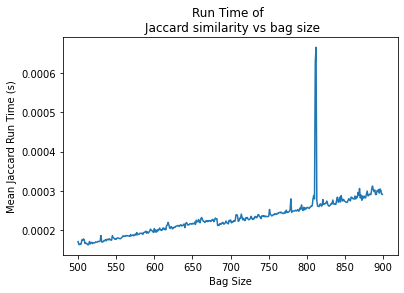

In [14]:
%matplotlib inline
x = list(range(500,len(doc_pair_list)+500))#list of bag size
y = list_jaccard_time

plt.xlabel('Bag Size')
plt.ylabel('Mean Jaccard Run Time (s)')
plt.title('Run Time of \n Jaccard similarity vs bag size')
plt.plot(x,y)


plt.show()



To find the time complexity we have to assume that the curve is in the form of $y = C_a.x^\alpha$.

Now we can take $log$ on both sides of the equation and make it in the form $log \,y = log(C_a) \, + \alpha \, log(x)$

This is now equation of a straight line where $log \, (C_a)$ is the intercept and $\alpha $ is the slope.

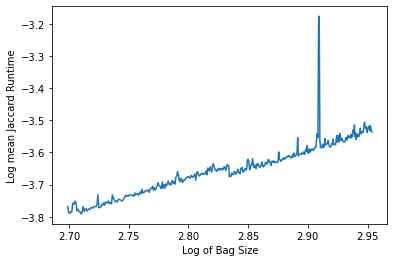

In [15]:
# Converting each element in the bag size list and the run time list to logarithmic vlaues with base 10
logx = [ np.log10(i )for i in x]
logy = [np.log10(i) for i in y]
#plotting the graph between the log values
plt.plot(logx,logy)
plt.ylabel("Log mean Jaccard Runtime")
plt.xlabel('Log of Bag Size')
plt.show()

In [16]:
slope_jaccard,intercept, r_value, p_value ,std_err = stats.linregress(logx,logy)
constant = np.power(10,intercept)
print("The slope is {} and the Constant for the computation is {}".format(slope_jaccard,constant))

The slope is 1.0018177411066098 and the Constant for the computation is 3.2318607591791417e-07


By running the **Jaccard's** algorithm multiple times, I have got $\alpha$ values ranging from $0.8$ to $1.2$ with mode value $\approx \, 0.95$ for multiple run  and the constant for the computation is of the order of $10^{-7}$. So the time complexity of our implementation is almost $O(n^{0.95})$ which is still better than the worst case run time of jaccards algorithm if the dict.keys() is implemented as list or if it has significant hash collisions.

Now from the emperical analysis we can write $y = 10^{-7} x^{0.95 }$ , where $y$ is the run time of the function and $x$ is the bag size.


# The Cosine Similarity

* Cosine similarity is also a mathematical concept which can be used to determine how similar two documents are by finding out the angle between the two vectors (the documents can be represented as vectors in the euclidean space). Smaller angle $\implies$ higher the $cos \, \theta$ and more similar the documents are.

* $cos\, \theta\, =\cfrac { \vec A\, \cdot \vec B}{ |A| * |B|} $

For calculating the cosine similarity, the list of pair of dictionaries which we already created is converted into **dense representation** ie as vectors.



In [17]:
#Function which generates dense vector pairs as numpy arrays for finding out the cosine similarity
def densevectors_asnparray(dict1,dict2):
  list1 = list(dict1.keys())
  list2 = list(dict2.keys())
  listtogather = list(set(list1 + list2)) # creating a list of unique keys from both the dict.keys() list
  list1f =[]
  list2f= []
  for i in listtogather: #for keys in dict1, it gives the corresponding values and otherwise it appends 0
    if i in dict1.keys():
      list1f.append(dict1[i])
    else:
      list1f.append(0)

  for i in listtogather: #for keys in dict2, it gives the corresponding values and otherwise it appends 0
    if i in dict2.keys():
      list2f.append(dict2[i])
    else:
      list2f.append(0)

  return np.asarray(list1f) ,np.asarray(list2f) #finally the funciton returns numpy vectors corresponding to each dictionary


The above created `densevectors_asnparray` is used to create a list of numpy vector pairs and it is stored in a new list `list_densevector_nppair `

In [18]:
# To generate list of densevector pair in numpy array form
list_densevector_nppair = []
for i in doc_pair_list:
  list_densevector_nppair.append(densevectors_asnparray(i[0],i[1]))




In [19]:
#stores the lenght of vector pairs created so that later it can be used to plot the list lenth vs run time graph
list_len_densevector_nppair = [len(i[0]) for i in list_densevector_nppair]


# Theoretical worst case running time of cosine similarity for vector iteration.

Here first I have created a cosine similarity function which doesn't use the full power of numpy array module. The function takes in two list of numpy array, but loops through each element in the array to find out the dot product of the vector as well as to find the modulus of each vector.

while running the created cosine similarity function `cosinesim_dot(A,B)` there are 4 for loops with time complexity of $O(n)$ which makes the entire function to have a time complexity of $\longrightarrow O(n)$



In [20]:
def modvec(vec): # Function to calculate the modulus of a vector
  sum = 0
  
  for i in vec:
    sum += i**2
  return np.sqrt(sum)

def cosinesim_dot(A,B):# function to calculate the cosine similarity by looping over individual element in the vector ie vector iteration
  sum = 0
  for i in range(len(A)):
    sum += A[i]*B[i]

  modA = modvec(A)
  modB = modvec(B)

  k = modA*modB

  return round(sum/k,4)


In [21]:
list_cosinesim_dot_time =[]
for i in list_densevector_nppair:
  k = time_it(cosinesim_dot,i[0],i[1],number_of_repeats = 100)
  list_cosinesim_dot_time.append(k)

In [22]:
#This list retains the cosine similarity values for vector iteration
list_cosinesim_dot_values = [cosinesim_dot(list_densevector_nppair[i][0],list_densevector_nppair[i][1]) for i in list(range(len(list_densevector_nppair)))]

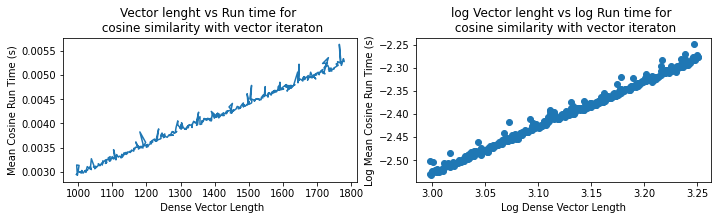

In [23]:

plt.subplots_adjust(1,0,2.5,0.5)

plt.subplot(121)
plt.plot(list_len_densevector_nppair,list_cosinesim_dot_time)


plt.xlabel(' Dense Vector Length')
plt.ylabel('Mean Cosine Run Time (s)')
plt.title('Vector lenght vs Run time for \n cosine similarity with vector iteraton')

plt.subplot(122)
x = list_len_densevector_nppair
y = list_cosinesim_dot_time

logX = np.log10(x)
logY = np.log10(y)

plt.scatter(logX,logY)
plt.title('log Vector lenght vs log Run time for \n cosine similarity with vector iteraton')
plt.xlabel('Log Dense Vector Length')
plt.ylabel('Log Mean Cosine Run Time (s)')
plt.show()

In [24]:
slope_cosine_vec, intercept, r_value, p_value, std_errd = stats.linregress(logX,logY)
constant = np.power(10, intercept)
print('The slope is {} and the constant for the computation is {}'.format(slope_cosine_vec,constant))

The slope is 0.9838215117159201 and the constant for the computation is 3.3383583350211773e-06


# Emperical time complexity observation of cosine similarity using vector iteration.

The $\alpha $ value of the equation has a mode value $\approx 0.98$ for multiple run $\implies O(n^{0.98})$, which makes justification to our theoretical prediction of the complexity as $O(n)$

Also the constant $C_a$ for the computation is of the order of $10^{-6}$.

So, emperically I can write the function as $y = 10^{-6} \, x^{0.98}$ , where $y$ is the run time of the function and $x$ is the length of the vectors.




# Theoretical time complexity of cosine similarity using numpy array

The advantage of numpy array is that the time complexity to access an element in an numpy array by using numpy methods is $O(1)$. Here in the new cosine similarity function I created, all the operations are carried out by using numpy methods, especially the `numpy.dot()` method. Unlike the cosine similarity with vector iteration, here the time complexity to get the dot product done is independent of the lenght of the vector ( numpy array). Also, I have given special attention to make sure that there is no conversion of list to numpy array is taking place inside the cosine function. If there is any list is converted to numpy array inside the cosine function, then the time complexity of the cosine function will be $O(n)$.

But, since in our function, There is no list to array conversion is taking place, the theoretical time complexity of our function should be $\longrightarrow O(1)$

In [25]:
# funcion to calculate cosine similarity using numpy module
def cosinesim_numpy(A,B):
  
  
  modA = np.sqrt(np.dot(A,A))
  modB = np.sqrt(np.dot(B,B))
  AdotB = np.dot(A,B)
  x = modA * modB

  cosinesimilarity = AdotB/x

  return round(cosinesimilarity,4)


In [26]:
list_cosinenp_time = []
for i in list_densevector_nppair:
  k = time_it(cosinesim_numpy,i[0],i[1],number_of_repeats=100)
  list_cosinenp_time.append(k)


In [27]:
#This list retains the values of cosine similarity by using numpy array dot product
list_cosinesim_numpy_values = [ cosinesim_numpy(list_densevector_nppair[i][0],list_densevector_nppair[i][1]) for i in list(range(len(list_densevector_nppair)))]

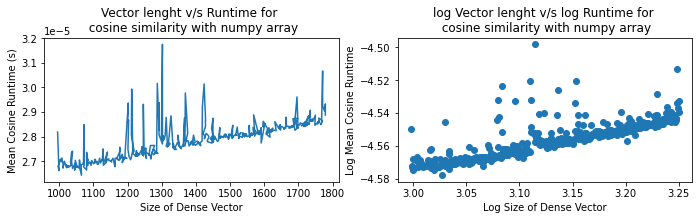

In [28]:
plt.subplots_adjust(1,0,2.5,0.5)

plt.subplot(121)
plt.plot(list_len_densevector_nppair,list_cosinenp_time)
plt.ylabel('Mean Cosine Runtime (s)')
plt.xlabel('Size of Dense Vector')
plt.title('Vector lenght v/s Runtime for \n cosine similarity with numpy array')

plt.subplot(122)
x = list_len_densevector_nppair
y = list_cosinenp_time
logX = np.log10(x)
logY = np.log10(y)
plt.scatter(logX,logY)
plt.xlabel('Log Size of Dense Vector')
plt.ylabel('Log Mean Cosine Runtime')
plt.title('log Vector lenght v/s log Runtime for \n cosine similarity with numpy array')
plt.show()

In [29]:
slope_cosine_np, intercept, r_value , p_value , std_err = stats.linregress(logX,logY)
constant = np.power(10,intercept)
print('The slope is {} and the Constant for the computation is {}'.format(slope_cosine_np,constant))

The slope is 0.11880960620933446 and the Constant for the computation is 1.1798704775751898e-05


# Emperical time complexity analysis for the cosine similarity implementation using numpy array methods.

The $\alpha $ value for the function is fluctuating between $0.01$ to $0.3$ in multiple runs of the algorithm, with the mode value $\approx 0.11$. The constant for the computation is of the order of $10^{-5}$.

So, emperically we can write $y= 10^{-5} x^{0.11}$ which is $\approx 10^{-5}$. which means that emperically also we got that the run time of the cosine similarity using numpy array methods are almost independent of the vector dimension.

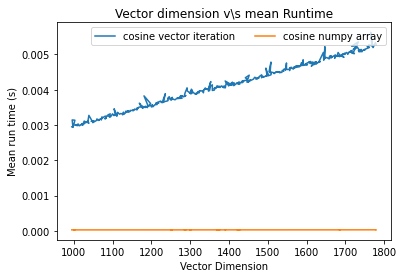

In [30]:
plt.plot(list_len_densevector_nppair,list_cosinesim_dot_time)
plt.plot(list_len_densevector_nppair,list_cosinenp_time)

plt.xlabel('Vector Dimension')
plt.ylabel('Mean run time (s)')
plt.title('Vector dimension v\s mean Runtime')
label =['cosine vector iteration', 'cosine numpy array']
plt.legend(label, loc = 1, ncol = 2)
plt.show()


From the above graph it is evident that cosine similarity using vector iteration takes higher time to compute than the numpy implementation. 






# Theoretical comparison of time complexity of cosine implementation using sparse dictionaries with other similarity implementations.

* The time complexity of the cosine similarity implementation using sparse dictionary will be $O(n)$ as there is a loop in the code to iterate through items in the dictionary

* While implementing the cosine similarity directly from sparse dictionaries, the size of the document we compare will be less since we don't have to convert it to the dense representation, as dense representation has more size. So, the run time will be better than the cosine implementation with vector iteration

* However, the run time of this will be not better than the run time of the cosine implementation using numpy, because while using numpy method each element can be accessed directly.

* The jaccard and cosine sparse have same time complexity $O(n)$

The following code takes in two dictionaries as input and directly calculate the  cosine similarity between them.

In [31]:
def dot(d1,d2):#Here the inputs are dictionaries
    if len(d1) < len(d2):
        a = d1
        b = d2
    else:
        a = d2
        b = d1
    dotproduct = 0
    #for each key in the dictionary1, if there is similar key in dictionary2, then the values of both the keys are multiplied and added to the 'dotproduct' 
    for word,count in a.items():
        dotproduct += count * b.get(word,0)
    return dotproduct

def cosinesim_sparse(d1,d2):
    numerator = dot(d1,d2)# calls the dot function created earlier
    denominator = np.sqrt(dot(d1,d1)*dot(d2,d2))
    return round(numerator/denominator,4)
  
    


In [32]:
#To get the list of average running time for cosine similarity using sparse(dictionary) representation
list_cosinesim_sparse_time = []
for i in doc_pair_list:
  k = time_it(cosinesim_sparse,i[0],i[1],number_of_repeats=100)
  list_cosinesim_sparse_time.append(k)


In [33]:
#This list retains the cosine similarity values for the sparse comparison
list_cosinesim_sparse_values = [cosinesim_sparse(doc_pair_list[i][0],doc_pair_list[i][1])    for i in list(range(len(doc_pair_list)))]

In [34]:
#The following list retains the list of lenght of the document pair list
list_len_doc_pair_list = [len(i[0]) for i in doc_pair_list]

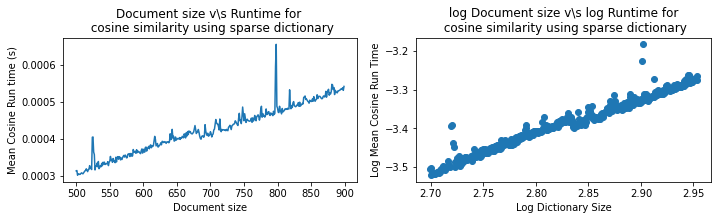

In [35]:
x = list_len_doc_pair_list
y = list_cosinesim_sparse_time
plt.subplots_adjust(1,0,2.5,0.5)
plt.subplot(121)
plt.plot(x,y)
plt.xlabel("Document size")
plt.ylabel("Mean Cosine Run time (s)")
plt.title('Document size v\s Runtime for \n cosine similarity using sparse dictionary')
plt.subplot(122)
logx = np.log10(x)
logy = np.log10(y)

plt.scatter(logx,logy)
plt.xlabel('Log Dictionary Size')
plt.ylabel('Log Mean Cosine Run Time')
plt.title(' log Document size v\s log Runtime for \n cosine similarity using sparse dictionary')

plt.show()

In [36]:
slope_cosine_sparse , intercept, r_value , p_value , std_err = stats.linregress(logx,logy)
constant = np.power(10,intercept)
print('The slope is {} and the constant for the computation is {}'.format(slope_cosine_sparse,constant))

The slope is 0.913659985988203 and the constant for the computation is 1.0676578391657417e-06


Emperically we have the time complexity of the cosine similarity implementation using sparse dictionary $\approx O(n^{0.9})$ which is slightly better than the theoretical worst case of $O(n)$

In [37]:
data = {'Jaccard similarity': list_jaccard_values,'cosine similarity(using vector iteration)':list_cosinesim_dot_values, 'cosine similarity(using numpy array)':list_cosinesim_numpy_values,'cosine similarity(using sparse representation)':list_cosinesim_sparse_values}

In [38]:
df = pd.DataFrame(data)
df

,Jaccard similarity,cosine similarity(using vector iteration),cosine similarity(using numpy array),cosine similarity(using sparse representation)
0,0.0199,0.0575,0.0575,0.0575
1,0.0003,0.0000,0.0000,0.0000
2,0.0100,0.0059,0.0059,0.0059
3,0.0179,0.0212,0.0212,0.0212
4,0.0029,0.0004,0.0004,0.0004
...,...,...,...,...
395,0.0045,0.0008,0.0008,0.0008
396,0.0117,0.0071,0.0071,0.0071
397,0.0079,0.0023,0.0023,0.0023
398,0.0092,0.0056,0.0056,0.0056


By observing the pandas Data Frame it is evident that though there is difference between the similarity measure of jaccard and cosine implementations(which is actually expected, since the fundamental method in which they calculate the similarity is different), all the different cosine implementations give the same similariy values for each pair of documents.

We can further use the cosine similarity for dense representation, which is already implemented to make sure the correctness of cosine similarity using sparse representation. We can consider the list of similarities we obtained already as two dense vectors and can be passed to the arguments of `cosinesim_numpy`. If the sparse representation is correct, the `cosinesim_numpy`should give an output equal to 1 or very close to 1

In [39]:
cosinesim_numpy(list_cosinesim_numpy_values,list_cosinesim_sparse_values)

1.0

We have obtained the out put to be equal to 1, which means that the sparse computation is gives exactly same result as the dense vector computaion and the implementation is correct.

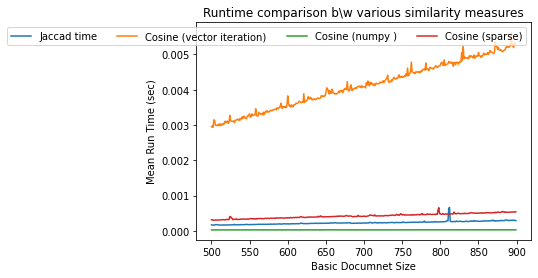

In [40]:
 plt.plot(list_len_doc_pair_list,list_jaccard_time)
 plt.plot(list_len_doc_pair_list,list_cosinesim_dot_time)
 plt.plot(list_len_doc_pair_list,list_cosinenp_time)
 plt.plot(list_len_doc_pair_list,list_cosinesim_sparse_time)
 label = ['Jaccad time','Cosine (vector iteration)','Cosine (numpy )','Cosine (sparse)']
 plt.legend(label, loc = 1, ncol =4)
 plt.xlabel('Basic Documnet Size')
 plt.ylabel('Mean Run Time (sec)')
 plt.title('Runtime comparison b\w various similarity measures')
 plt.show()


From the above graph the following conclusions can be made
* Cosine similarity using the numpy array module is has the least running time followed by jaccard's algorithm which is followed by cosine sparse.

* Cosine similarity using vector iteration has the worst running time for a given document size among all the four similarity implementations.


# All pair similarity



A function `all_pair_comparison` which computes all pair similarities for a collection of documents is created. The function takes a list of dictionaries as the input `list_of_documnents` and there is a parameter which can be varied to specify the similarity measure to be used `method`

The parameter `method` is 
* "jaccard" $\longrightarrow $        jaccard similarity (default)
* "cosine_vector" $\longrightarrow $ cosine similarity using vector iteration
* "cosine_numpy" $\longrightarrow $ cosine similariy using numpy array method
* "cosine_sparse" $\longrightarrow $ cosine similarity using sparse dictionary

In [41]:
def all_pair_comparison(list_of_documents, method= 'jaccard'):
  all_pair_similarity = []
  #for jaccard similarity
  if method =='jaccard':
    for i in list_of_documents:
      for j in list_of_documents:
        all_pair_similarity.append(jaccard(i,j))
  #for cosine similarity using vector iteration      
  if method == 'cosine_vector':
    for i in list_of_documents:
      for j in list_of_documents:
        a,b = densevectors_asnparray(i,j)
        k = cosinesim_dot(a,b)
        all_pair_similarity.append(k)
  #for cosine similarity using numpy dot operation
  if method == 'cosine_numpy':
    for i in list_of_documents:
      for j in list_of_documents:
        a,b = densevectors_asnparray(i,j)
        k = cosinesim_numpy(a,b)
        all_pair_similarity.append(k)
  #for cosine similarity using sparse dictionaries
  if method == 'cosine_sparse':
    for i in list_of_documents:
      for j in list_of_documents:
        k = cosinesim_sparse(i,j)
        all_pair_similarity.append(k)


  return all_pair_similarity




# Theoretical worst case running time for computing all-pair similariy

In order to run the all-pair similarity we should have a nested loop to iterate through all the documents vs all the documents $O(n^2)$. In the inner loop then the corresponding similarity measure $O(n)$ has to run. (Note : both '$n$' are different, first '$n$' is size of list of dictionaries and the second '$n$' is size of largest individual dictionary in the list)

So, the time complexity of all-pair similarity depends on the size of the list of dictionaries and the size of individual dictionary in the list.

Assuming the size of individual dictionary is similar to the size of the list of dictionaries, the worst case time complexity for all the similarity measures we considered except cosine similarity implementation using numpy module will be $\longrightarrow$ $O(n^3)$

But, since the size of individual dictionary doesn't affect the cosine numpy implementation, the time complexity for all-pair similarity for it will be $\longrightarrow O(n^2)$


However if we keep the size of dictionaries constant and we only vary the size of list of dictionaries, then the time complexity for all the similarity measure methods will be $\longrightarrow O(n^2)$



In [42]:
# created a list of 16 documents with each dictionary has a bag size of 1000
all_pair_doc_list = doc_creation(1000,16)

In [43]:
# Here the method can be changed to other similarity methods and all pair similarity for different methods can be found for the 'all_pair_doc_list'
print(all_pair_comparison(all_pair_doc_list,method = 'cosine_numpy'))

[1.0, 0.0023, 0.0235, 0.0073, 0.0019, 0.0097, 0.1089, 0.0196, 0.0009, 0.3238, 0.005, 0.0414, 0.0152, 0.0024, 0.0122, 0.0028, 0.0023, 1.0, 0.0051, 0.003, 0.0053, 0.0084, 0.0055, 0.0008, 0.001, 0.0111, 0.003, 0.001, 0.0016, 0.0013, 0.066, 0.0508, 0.0235, 0.0051, 1.0, 0.0357, 0.019, 0.019, 0.0076, 0.1117, 0.0289, 0.0101, 0.0291, 0.0098, 0.0004, 0.0139, 0.0229, 0.0223, 0.0073, 0.003, 0.0357, 1.0, 0.1465, 0.0669, 0.001, 0.0087, 0.003, 0.1334, 0.0041, 0.0164, 0.0003, 0.0012, 0.0005, 0.0552, 0.0019, 0.0053, 0.019, 0.1465, 1.0, 0.0035, 0.003, 0.0057, 0.0131, 0.1391, 0.0021, 0.0111, 0.0054, 0.0045, 0.0116, 0.0004, 0.0097, 0.0084, 0.019, 0.0669, 0.0035, 1.0, 0.0056, 0.0194, 0.0531, 0.0001, 0.0006, 0.0026, 0.0045, 0.3519, 0.0052, 0.001, 0.1089, 0.0055, 0.0076, 0.001, 0.003, 0.0056, 1.0, 0.0271, 0.049, 0.1317, 0.0252, 0.002, 0.0004, 0.0042, 0.245, 0.0024, 0.0196, 0.0008, 0.1117, 0.0087, 0.0057, 0.0194, 0.0271, 1.0, 0.01, 0.0011, 0.0001, 0.0024, 0.0099, 0.0032, 0.0389, 0.0065, 0.0009, 0.001, 0.0289

In [44]:
#genereates a list of list of dictionaries where the lenght of individual dictionary is same as the size of list of dictionary
list_of_list_all_pair_doc = []
for i in range(50,65):
  list_of_list_all_pair_doc.append(doc_creation(i,i))

In [45]:
#The run time of all pair similarity  using jaccard's similarity for list of list of dictionaries is stored in 'list_of_list_all_pair_run_time'
list_of_list_all_pair_run_time =[]
for i in range(len(list_of_list_all_pair_doc)):
  k = time_it(all_pair_comparison,list_of_list_all_pair_doc[i])
  list_of_list_all_pair_run_time.append(k)

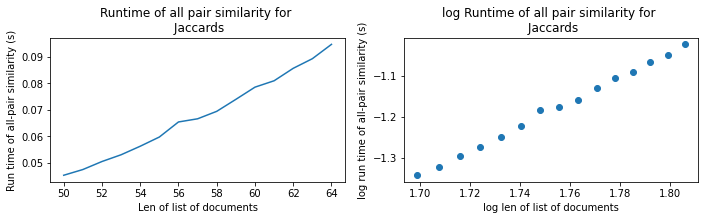

In [46]:
y = list_of_list_all_pair_run_time
x = range(50,65)

plt.subplots_adjust(1,0,2.5,0.5)
plt.subplot(121)
plt.plot(x,y)
plt.xlabel('Len of list of documents')
plt.ylabel('Run time of all-pair similarity (s)')
plt.title('Runtime of all pair similarity for \n Jaccards')

plt.subplot(122)
logx = np.log10(x)
logy = np.log10(y)
plt.scatter(logx,logy)
plt.xlabel('log len of list of documents')
plt.ylabel('log run time of all-pair similarity (s)')
plt.title('log Runtime of all pair similarity for \n Jaccards')

plt.show()

In [47]:
slope, intercept, r_value, p_value , std_err = stats.linregress(logx,logy)
constant = np.power(10, intercept)
print('The slope is {} and the constant for the computation is {}'.format(slope,constant))

The slope is 2.9866646132987693 and the constant for the computation is 3.8008576157202733e-07


From the above emperical analysis of time complexity of all-pair similarity using Jaccard's method the following conclusion can be made

* $\alpha \, \approx 3.1  $ and  $C_a \approx 10^{-7} \implies$ the worst case time complexity of all-pair similarity is $\longrightarrow O(n^{3.1})$ which justifies the theoretical worst case run time prediction.

* The run time vs length of all pair similarity can be represented as $y=10^{-7} x^{3.1}$



In [48]:
list_of_list_all_pair_run_time_cosine =[]
for i in range(len(list_of_list_all_pair_doc)):
  k = time_it(all_pair_comparison,list_of_list_all_pair_doc[i],method = 'cosine_sparse')
  list_of_list_all_pair_run_time_cosine.append(k)

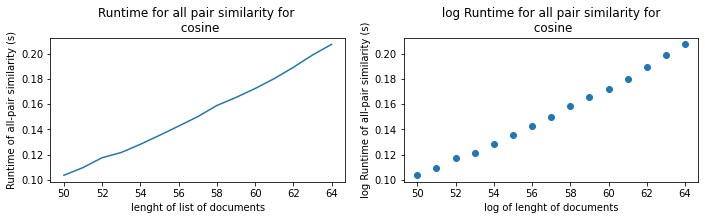

In [49]:
y = list_of_list_all_pair_run_time_cosine
x = list(range(50,65))

plt.subplots_adjust(1,0,2.5,0.5)

plt.subplot(121)
plt.plot(x,y)
plt.ylabel('Runtime of all-pair similarity (s)')
plt.xlabel('lenght of list of documents')
plt.title('Runtime for all pair similarity for \n cosine')
plt.subplot(122)

logx = np.log10(x)
logy = np.log10(y)

plt.scatter(x,y)
plt.xlabel('log of lenght of documents')
plt.ylabel('log Runtime of all-pair similarity (s)')
plt.title(' log Runtime for all pair similarity for \n cosine')
plt.show()

In [50]:
slope , intercept, r_value, p_value, std_err = stats.linregress(logx, logy)
constant = np.power(10,intercept)
print('The slope is {} and the constant for the computation is {}'.format(slope , constant))

The slope is 2.7933576188189284 and the constant for the computation is 1.8661704334085395e-06


From the emperical analysis of all-pair time complexity for cosine similarity with sparse representation
* $\alpha \, \approx 2.9  $ and  $C_a \approx 10^{-6} \implies$ the worst case time complexity of all-pair similarity is $\longrightarrow O(n^{2.9})$ which justifies the theoretical worst case run time prediction.

* The run time vs length of all pair similarity can be represented as $y=10^{-6} x^{2.9}$





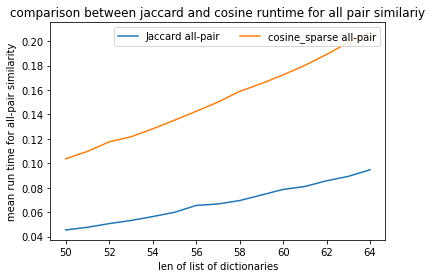

In [51]:
plt.plot(list(range(50,65)),list_of_list_all_pair_run_time)
plt.plot(list(range(50,65)),list_of_list_all_pair_run_time_cosine)
plt.ylabel('mean run time for all-pair similarity')
plt.xlabel('len of list of dictionaries')
label = ['Jaccard all-pair', 'cosine_sparse all-pair']
plt.title('comparison between jaccard and cosine runtime for all pair similariy')
plt.legend(label, loc =1 , ncol = 2)
plt.show()

From the graph it is evident that for smaller size of list of list of dictionaries, Jaccard's similarity takes less time to run compared to cosine sparse implementation. Also, from the graph it seems like the slope of cosine sparse all-pair run time increases with increasing size of list of list of dictonaries.

# Time prediction for running all-pair similarity for 200k documents
From the obtained equations for Jaccard's and cosine sparse and substituting 200,000

### If individual document size is also in the order of 200k:

* If jaccard's is used: $y \approx 10^{-7} 200000^{3.1} \implies 2.7\times 10^{9}s$
* If cosine_sparse is used: $y \approx 10^{-6} 200000^{2.9} \implies 2.36\times 10^{8}s$ $\longrightarrow$ But this value is probably a wrong prediction because the slope of the cosine sparse increases as the lenght of list of list increases, and it is supposed to give a higher run time than the Jaccard's algorithm

### If individual document size is very small compared to 200k:
then the time complexity $\approx O(n^2)$ 
* If Jaccard's is used: $y \approx 10^{-7} 200000^{2} \implies 4\times 10^{3}s$
* If cosine_sparse is used: $y \approx 10^{-6} 200000^{2} \implies 4\times 10^{4} s$ 



# All pair similarity for Jaccard using parallel processing (Map Reduce Paradigm)

## Map Reduce paradigm

Is used to do parallel processing of the given task by splitting the data into differnt chunks and by making use of all the cores at the same time and completing the whole task efficiently. Here, the map reduce is used in such a way that the mapper will calculate the similarity and will iterate over the input given and reducer will just collect output from the collector and join it.Also, I have used google colab and collab has assigned only 2 cores. So the sum of number of mappers and reducers should be equal to 2 and hence I have assigned 1 mapper and 1 reducer processess.

In [52]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

4

In [53]:


# Defining the mapper function for the map-reduce implementation
def Mapper_all_pair_jaccard(doc_):
  list_output = []
  (i,j,doc_i,doc_j) = doc_
  

  similarity_ = jaccard(doc_i,doc_j)
  list_output.append(((i,j),similarity_))
  return list_output

In [54]:
def map_reduce_parallel(inputs,mapper,reducer,mapprocesses=1,reduceprocesses=1):
    
    collector=defaultdict(list)  #this dictionary is where we will store intermediate results
                                 #it will map keys to lists of values (default value of a list is [])
                                 #in a real system, this would be stored in individual files at the map nodes
                                 #and then transferred to the reduce nodes
    
    mappool = Pool(processes=mapprocesses)
    #map stage
    
    mapresults=mappool.map(mapper,inputs)
    mappool.close()
    
    for mapresult in mapresults:
        for (key, value) in mapresult:     #pass each input to the mapper function and receive back each key,value pair yielded
            collector[key].append(value)     #append the value to the list for that key in the intermediate store
            
    #reduce stage 
    outputs=[]
    reducepool = Pool(processes=reduceprocesses)
    
    reduceresults=reducepool.map(reducer,collector.items())
    reducepool.close()
    for reduceresult in reduceresults:
        outputs+=reduceresult
   
    return outputs

In [55]:
#Defining the reducer function for the map-reduce implementation
def reducer_all_pair(item):
  (keys,values) = item
  output_reducer = [(keys,values)]
  return (output_reducer)

In [56]:
def mapreduce_allpair_jaccard (all_pair_docc_list):
  mapper_iterator = []
  for i in range(len(all_pair_docc_list)):
    for j in range (len(all_pair_docc_list)):
      mapper_iterator.append((i,j,all_pair_docc_list[i],all_pair_docc_list[j]))

  return map_reduce_parallel(mapper_iterator,Mapper_all_pair_jaccard,reducer_all_pair)

In [57]:
#stores result as a list of tuples with doument index and corresponding similarity measure
result_jaccard = mapreduce_allpair_jaccard(all_pair_doc_list)

In [58]:
print(result_jaccard)

[((0, 0), [1.0]), ((0, 1), [0.0067]), ((0, 2), [0.0178]), ((0, 3), [0.0132]), ((0, 4), [0.0061]), ((0, 5), [0.0133]), ((0, 6), [0.026]), ((0, 7), [0.0175]), ((0, 8), [0.0055]), ((0, 9), [0.0614]), ((0, 10), [0.0159]), ((0, 11), [0.0273]), ((0, 12), [0.013]), ((0, 13), [0.0067]), ((0, 14), [0.014]), ((0, 15), [0.01]), ((1, 0), [0.0067]), ((1, 1), [1.0]), ((1, 2), [0.0074]), ((1, 3), [0.0091]), ((1, 4), [0.0124]), ((1, 5), [0.0116]), ((1, 6), [0.0107]), ((1, 7), [0.005]), ((1, 8), [0.0051]), ((1, 9), [0.0139]), ((1, 10), [0.0115]), ((1, 11), [0.0053]), ((1, 12), [0.0055]), ((1, 13), [0.0056]), ((1, 14), [0.0296]), ((1, 15), [0.0215]), ((2, 0), [0.0178]), ((2, 1), [0.0074]), ((2, 2), [1.0]), ((2, 3), [0.0277]), ((2, 4), [0.0132]), ((2, 5), [0.0121]), ((2, 6), [0.0122]), ((2, 7), [0.0351]), ((2, 8), [0.0199]), ((2, 9), [0.0107]), ((2, 10), [0.0251]), ((2, 11), [0.0172]), ((2, 12), [0.0025]), ((2, 13), [0.0152]), ((2, 14), [0.0204]), ((2, 15), [0.0233]), ((3, 0), [0.0132]), ((3, 1), [0.0091

In [59]:
jaccard_values =all_pair_comparison(all_pair_doc_list,method='jaccard')
document_index = [i[0] for i in result_jaccard]
jaccard_similarity_mr = [i[1] for i in result_jaccard]


In [60]:
data = {'document index': document_index, 'jaccard similarity using mapreduce': jaccard_similarity_mr, 'jaccard similarity without mapreduce': jaccard_values }
df_jacc = pd.DataFrame(data)
df_jacc

,document index,jaccard similarity using mapreduce,jaccard similarity without mapreduce
0,"(0, 0)",[1.0],1.0000
1,"(0, 1)",[0.0067],0.0067
2,"(0, 2)",[0.0178],0.0178
3,"(0, 3)",[0.0132],0.0132
4,"(0, 4)",[0.0061],0.0061
...,...,...,...
251,"(15, 11)",[0.0309],0.0309
252,"(15, 12)",[0.0159],0.0159
253,"(15, 13)",[0.0084],0.0084
254,"(15, 14)",[0.0224],0.0224


From the above comparison it is evident that jaccar similarity with mapreduce gives same results as jaccard similarity without mapreduce. So, the Map Reduce implementation is correct

# All pair similarity using cosine similarity using parallel processing

In [61]:
#defining mapper function for cosine similarity 
def Mapper_all_pair_cosine(doc_):
  list_output = []
  (i,j,doc_i,doc_j) = doc_
  

  similarity_ = cosinesim_sparse(doc_i,doc_j)
  list_output.append(((i,j),similarity_))
  return list_output

In [62]:
#defining the main mapreduce function to be called for computing cosine similarity
def mapreduce_allpair_cosine (all_pair_docc_list):
  mapper_iterator = []
  for i in range(len(all_pair_docc_list)):
    for j in range (len(all_pair_docc_list)):
      mapper_iterator.append((i,j,all_pair_docc_list[i],all_pair_docc_list[j]))

  return map_reduce_parallel(mapper_iterator,Mapper_all_pair_cosine,reducer_all_pair)

In [63]:
#stores result as a list of tuples with doument index and corresponding similarity measure
result_cosine = mapreduce_allpair_cosine(all_pair_doc_list)

In [64]:
print(result_cosine) 

[((0, 0), [1.0]), ((0, 1), [0.0023]), ((0, 2), [0.0235]), ((0, 3), [0.0073]), ((0, 4), [0.0019]), ((0, 5), [0.0097]), ((0, 6), [0.1089]), ((0, 7), [0.0196]), ((0, 8), [0.0009]), ((0, 9), [0.3238]), ((0, 10), [0.005]), ((0, 11), [0.0414]), ((0, 12), [0.0152]), ((0, 13), [0.0024]), ((0, 14), [0.0122]), ((0, 15), [0.0028]), ((1, 0), [0.0023]), ((1, 1), [1.0]), ((1, 2), [0.0051]), ((1, 3), [0.003]), ((1, 4), [0.0053]), ((1, 5), [0.0084]), ((1, 6), [0.0055]), ((1, 7), [0.0008]), ((1, 8), [0.001]), ((1, 9), [0.0111]), ((1, 10), [0.003]), ((1, 11), [0.001]), ((1, 12), [0.0016]), ((1, 13), [0.0013]), ((1, 14), [0.066]), ((1, 15), [0.0508]), ((2, 0), [0.0235]), ((2, 1), [0.0051]), ((2, 2), [1.0]), ((2, 3), [0.0357]), ((2, 4), [0.019]), ((2, 5), [0.019]), ((2, 6), [0.0076]), ((2, 7), [0.1117]), ((2, 8), [0.0289]), ((2, 9), [0.0101]), ((2, 10), [0.0291]), ((2, 11), [0.0098]), ((2, 12), [0.0004]), ((2, 13), [0.0139]), ((2, 14), [0.0229]), ((2, 15), [0.0223]), ((3, 0), [0.0073]), ((3, 1), [0.003]),

In [65]:
cosine_values =all_pair_comparison(all_pair_doc_list,method='cosine_sparse')
document_index = [i[0] for i in result_cosine]
cosine_similarity_mr = [i[1] for i in result_cosine]


In [66]:
data = {'document index': document_index, 'cosine similarity using mapreduce': cosine_similarity_mr, 'cosine similarity without mapreduce': cosine_values }
df_cos = pd.DataFrame(data)
df_cos

,document index,cosine similarity using mapreduce,cosine similarity without mapreduce
0,"(0, 0)",[1.0],1.0000
1,"(0, 1)",[0.0023],0.0023
2,"(0, 2)",[0.0235],0.0235
3,"(0, 3)",[0.0073],0.0073
4,"(0, 4)",[0.0019],0.0019
...,...,...,...
251,"(15, 11)",[0.0302],0.0302
252,"(15, 12)",[0.0192],0.0192
253,"(15, 13)",[0.0049],0.0049
254,"(15, 14)",[0.0436],0.0436


In [67]:
#creates list of 100 dictionaries with bag size of 100
all_pair_doc_list_100 = doc_creation(100,100)
all_pair_doc_list_100[0]

{'caricature': 2,
 'murkland': 2,
 'gasket': 4,
 'nicest': 1,
 'vindicate': 1,
 'procreative': 2,
 'weaves': 2,
 'precedent': 9,
 'kill': 63,
 'audits': 1,
 'transcend': 1,
 'pleas': 3,
 'coated': 4,
 'fluff': 1,
 'blatz': 9,
 'intergroup': 3,
 'allowances': 25,
 'international': 155,
 'occurs': 27,
 'remembrance': 2,
 'help': 311,
 'earning': 9,
 'logical': 34,
 'bois': 2,
 'slothful': 1,
 'mimetically': 1,
 'molding': 15,
 'pulpits': 1,
 'raccoon': 1,
 'duress': 1,
 'comments': 30,
 'centigrade': 1,
 'adagios': 1,
 'coverage': 25,
 'shrinkage': 3,
 'radically': 13,
 'salable': 1,
 'haskins': 1,
 'militarily': 3,
 'attachments': 4,
 'honour': 2,
 'pushes': 3,
 'bridgehead': 2,
 'javert': 1,
 'fiscal': 120,
 'kinds': 36,
 'sp': 2,
 'furthered': 3,
 'veneration': 3,
 'fences': 16,
 'drilled': 5,
 'stubs': 2,
 'mess': 22,
 'daughter': 72,
 'degassed': 1,
 'rychard': 1,
 'chairmanships': 1,
 'track': 38,
 'cognizant': 2,
 'merveilleux': 1,
 'tripolyphosphate': 2,
 'exoneration': 2,
 'sain

In [68]:
#the average time taken to run the all pair similarity using MapReduce is found out

a=time_it(mapreduce_allpair_jaccard,all_pair_doc_list_100,number_of_repeats=5)
b=time_it(mapreduce_allpair_cosine,all_pair_doc_list_100,number_of_repeats=5)
print('The average time taken to find all pair similarity of 100 documents with bagsize of 100: \n {} seconds using jaccard \n {} seconds using cosine'.format(a,b))

The average time taken to find all pair similarity of 100 documents with bagsize of 100: 
 0.8911598682403564 seconds using jaccard 
 1.3795688152313232 seconds using cosine


The run time for all pair similarity we calculated for 100 documents is actually greater than the runtime required without using map reduce. This is because for small number of documents map reduce is less efficient than normal process. But as we take large number of documents mapreduce will give better efficiency than normal calculations.

# Summary
In this report I have analysed the time complexity of Jaccard's and different cosine smiliarity implementations theoretically as well as emperically. It is found that cosine similarity using numpy array has the least time complexity $O(1)$ and other similarity measures are of $O(n)$. However, cosine similarity using vector iteration is very time consuming compared to other methods event though other methods (except cosine using numpy) also has time complexity of $O(n)$.

Further, I have created function to calculate all pair similarity with parameter specifying similarity measure. And finally a map reduce paradigm is implemented for implementing parallel processing.
However the map-reduce computing paradigm has to be tested for mass data processing with high number of cores/computers in order to know the full potential of it, which is beyond the scope of this report.
